## L4 - More Probabilistic Reasoning - Continuous

### Barber Example 1.11 (Pendulum)

Suppose that we have noisy measurements of pendulum that oscillates with some unknown frequency. Further, we assume oscillation angle is small so that it is approximately sinusoidal.  First we synthesize some data:

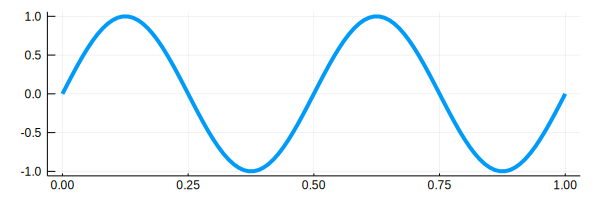

In [2]:
using Plots
default(legend=false, size=(600,200))

ftrue = 2 # true (but unknown) frequency, in Hz
t = 0:0.01:1
x = sin.(2π * ftrue .* t)
plot(t, x, lw=4, legend=false)

#### Synthesizing Noisy Observations

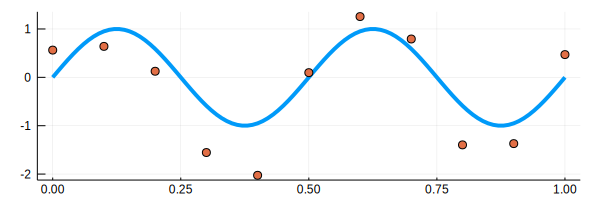

In [3]:
using Random, Distributions

tm = 0:0.1:1 # sample times of the measurments
T=length(tm)
σ = 0.5
ε = rand(Normal(0, σ), T) 
xm = sin.(2π * ftrue .* tm) .+ ε

plot(t, x, lw=4)
scatter!(tm, xm) # ! means modify existing plot

Of course, we don't get to see the sine wave.  We only see the data.

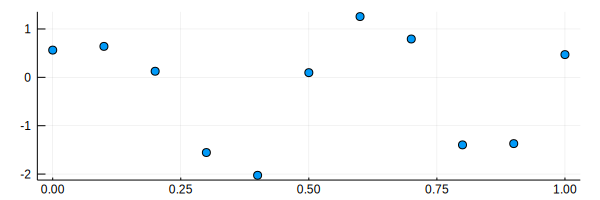

In [4]:
scatter(tm, xm)

#### Bayesian Inference

Give only these measurements, how can we estimate the frequency?

The general procedure for Bayesian modeling and inference:
1. construct a *generative* model
2. use Bayes' rule to derive the posterior
3. estimate the frequency from the posterior

Use Bayes' rule to estimate parameters $\theta$ from data $\cal{D}$

$$
p(\theta|\mathcal{D}) = 
\frac
{p(\mathcal{D} | \theta) p(\theta)}
{p(\mathcal{D})}
$$

The likelihood $p(\cal{D} | \theta)$ is a **generative model** which gives the probability of the data $\cal{D}$ given model (or parameters) $\theta$.  If we wanted, we could be more explicit about the model we are using:

$$
p(\theta|\mathcal{D}, M) = 
\frac
{p(\mathcal{D} | \theta, M) p(\theta | M)}
{p(\mathcal{D} | M)}
$$

In this example, the data is a sine wave with additive noise:

$$
x(t) = \sin(2\pi f t) + \epsilon(t), 
$$

In the Barber example, $\theta = 2\pi f$. (Aside, Barber uses the notation $x_t$, which uses $t$ as an index.  This, however, risks conflating the *time* of the `i`th sample with the index of that sample. Here, we will keep them separate and use an actual time axis.  We will use $x(t)$ and keep in mind that we only have measurements at a discrete set of times.)

Although this function is a model, it isn't a *probabilistic model*. We need to express the *probability* of observing the data $\mathcal{D} = x_1 \ldots x_T$ (note that here, the indices are actual indices).

#### The Probability of the Data

If we assume that the noise is Gaussian

$$
\varepsilon(t) \sim \mathcal{N}(0, \sigma),
$$

then the probility of a data point $x_t$ is

$$
p(x(t) | f, \sigma) = \mathcal{N}(\varepsilon(t), \sigma), 
$$

where $\varepsilon(t) = x(t) - \sin(2\pi f t)$.  If we assume the samples are independent, then we can write

$$
p(x_1 \ldots x_T | f) = \prod_{i=1}^T p(x_i | f) .
$$

#### A Uniform Prior
This gives us the likelihood, but what about the prior $p(f)$?

Method 1: The easy way out. If we assume a uniform prior for the frequency over a "reasonable" range, then we can just maximumize the likelihood.  In fact, we don't even have to define exactly what the prior is, because we can always define it to be large enough, and it's still a constant.

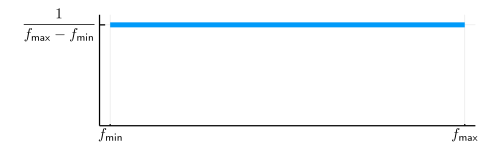

In [5]:
using LaTeXStrings
plot([0,1], [1,1], lw=4, ylims=(0,1.1), 
     xticks=([0,1], [L"f_{\sf min}", L"f_{\sf max}"]),
     yticks=([1], [L"\frac{1}{f_{\sf max}-f_{\sf min}}"]),
     size=(500,150), thickness_scaling=1.25)

#### Maximum Likelihood

When the prior is constant (as is $p(\mathcal{D})$), maximizing the posterior is identical to maximizing $f$ over the likelihood, which is called *maximum likelihood*.  Naïvely, we might try to define it directly:

In [25]:
? pdf

search: pdf logpdf logpdf! gradlogpdf Cptrdiff_t componentwise_pdf



```
pdf(d::UnivariateDistribution, x::Real)
```

Evaluate the probability density (mass) at `x`.

See also: [`logpdf`](@ref).

---

```
pdf(d::MultivariateDistribution, x::AbstractArray)
```

Return the probability density of distribution `d` evaluated at `x`.

  * If `x` is a vector, it returns the result as a scalar.
  * If `x` is a matrix with n columns, it returns a vector `r` of length n, where `r[i]` corresponds

to `x[:,i]` (i.e. treating each column as a sample).

`pdf!(r, d, x)` will write the results to a pre-allocated array `r`.

---

```
pdf(d::MatrixDistribution, x::AbstractArray)
```

Compute the probability density at the input matrix `x`.

---

```
pdf(d::Union{UnivariateMixture, MultivariateMixture}, x)
```

Evaluate the (mixed) probability density function over `x`. Here, `x` can be a single sample or an array of multiple samples.


In [6]:
likelihood(t, x, f, σ) = pdf(Normal(0, σ), x - sin(2π*f*t))

likelihood (generic function with 1 method)

This works for scalars:

In [7]:
likelihood(tm[1], xm[1], ftrue, σ)

0.4230691823318306

and can be applied to vector arguments with the [dot syntax](https://docs.julialang.org/en/v1.1/manual/functions/#man-vectorized-1), which works automatically:

In [8]:
likelihood.(tm, xm, ftrue, σ)

11-element Array{Float64,1}:
 0.4230691823318306 
 0.6575450589526722 
 0.5207611294755939 
 0.12308095028277652
 0.07937008059840123
 0.7830341298820515 
 0.6622119812612436 
 0.7335983072296107 
 0.21588405630294993
 0.5615994453051651 
 0.5126219379213401 

But this gives the likelihood for each point.  We need to product, but we haven't defined what to do in the case where `x` is a vector (or, as we've been using it, a `range`).

In [9]:
likelihood(tm, xm, ftrue, σ)

MethodError: MethodError: no method matching sin(::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}})
Closest candidates are:
  sin(!Matched::BigFloat) at mpfr.jl:736
  sin(!Matched::Missing) at math.jl:1070
  sin(!Matched::Complex{Float16}) at math.jl:1019
  ...

To define it, we use a type annotation:

In [10]:
likelihood(t::AbstractArray, x::AbstractArray, f, σ) = 
    prod(likelihood.(t, x, f, σ))

likelihood (generic function with 2 methods)

Julia knows which `likelihood` method to call based on the types of the arguments. (Aside: We use `AbstractArray` so the function can accept either an array or a range).

In [11]:
likelihood(tm, xm, ftrue, σ)

3.3458279625914075e-5

This works fine, but when we have non-small amounts of data, it will lead to numerical error, so it's better to compute the log likelihood:

$$
\log p(x_1 \ldots x_T | f) = \sum_{i=1}^T \log p(x_i | f) .
$$

All we have to do is redefine our functions:

In [12]:
logL(t, x, f, σ) = logpdf(Normal(0, σ), x - sin(2π*f*t))
logL(t::AbstractArray, x::AbstractArray, f, σ) = sum(logL.(t, x, f, σ))

logL (generic function with 2 methods)

In [13]:
logL(t, x, ftrue, σ)

-22.804926617117474

In [14]:
log(likelihood(t, x, ftrue, σ))

-22.804926617117463

#### Finding the Most-likely Value

Now all we have to do is find the frequency that maximizes the log likelihood.  Since we're using a Gaussian noise model, this is equivalent to minimizing the mean squared error.

In [15]:
frange = 1:0.1:3
logLf = [logL(tm, xm, f, σ) for f in frange]
i = argmax(logLf)
f_ML = frange[i]
maxlogL = logLf[i]
@show f_ML maxlogL;

f_ML = 2.1
maxlogL = -10.279990029444482


In [16]:
[frange logLf]

21×2 Array{Float64,2}:
 1.0  -45.6618
 1.1  -47.8444
 1.2  -50.9798
 1.3  -52.6445
 1.4  -51.0146
 1.5  -46.2502
 1.6  -39.5545
 1.7  -31.6886
 1.8  -23.1038
 1.9  -15.1763
 2.0  -10.3052
 2.1  -10.28  
 2.2  -14.8498
 2.3  -22.222 
 2.4  -30.6495
 2.5  -39.0189
 2.6  -46.0977
 2.7  -50.1677
 2.8  -50.1322
 2.9  -46.7944
 3.0  -42.4306

Note: The maximum likelihood frequency isn't necessarily equal to the true frequency due to noise.

In [17]:
using Interact, Printf

@manipulate for f in slider(frange, value=f_ML, label="frequency")
    x = sin.(2π * f .* t)
    plot(t, x, lw=4)
    s = @sprintf("%.2f", logL(tm, xm, f, σ))
    scatter!(tm, xm, 
        title=latexstring("f=$f Hz \\quad \\log p(\\mathcal{D}|f)=$s"))
end

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9575bc5ad81ee7e66e57ef0d6ecc62e635a6a6be-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9575bc5ad81ee7e66e57ef0d6ecc62e635a6a6be-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:f=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
12,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9"  …  "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"2.1",:value=>Observable{Float64} with 2 listeners. Value:
2.1), Observable{Float64} with 2 listeners. Value:
2.1, Scope("knockout-component-07f94800-e613-4507-a73f-b67d206af73b", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["frequency"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>21,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9"  …  "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"2.1", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Any["knockout"=>"/home/lcl/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/home/lcl/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/home/lcl/.julia/packages/InteractBase/3SqBl/src/../assets/all.js", "/home/lcl/.julia/packages/InteractBase/3SqBl/src/../assets/style.css", "/home/lcl/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"1.0\\\",\\\"1.1\\\",\\\"1.2\\\",\\\"1.3\\\",\\\"1.4\\\",\\\"1.5\\\",\\\"1.6\\\",\\\"1.

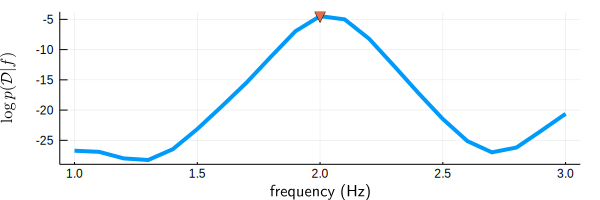

In [17]:
p1 = plot(t, x, lw=4, xlabel="t", ylabel="x(t)")
p1 = scatter!(p1, tm, xm)

p2 = plot(frange, logLf, lw=4, 
    xlabel=L"\textsf{frequency (Hz)}", ylabel=L"\log p(\mathcal{D}|f)")
p2 = scatter!([f_ML], [maxlogL], m=:dtriangle, msize=6)

# TODO: use interact with subplots
#plot(p1, p2, layout=(1,2))
plot(p2)

This is deceptive, however, since the search range is right around the answer.  If we exand it, it looks like this:

In [25]:
frange = 0.01:0.01:10
logLf = [logL(tm, xm, f, σ) for f in frange];

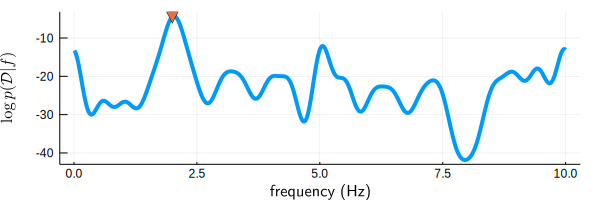

In [27]:
plot(frange, logLf, lw=4, 
    xlabel=L"\textsf{frequency (Hz)}", ylabel=L"\log p(\mathcal{D}|f)")
scatter!([f_ML], [maxlogL], m=:dtriangle, msize=6)

#### Maximum A Posteriori - Adding Prior Information

